# Mutual Information-based Registration

## Introduction
In this exercise, you will implement 3D rigid image registration using mutual information (MI). You will work with a T1-weighted and a T2-weighted MRI scan of the same patient, where the patient is lying in a different position in the scanner between the two image acquisition (for the purpose of this exercise, the movement is simulated).

### Instructions for your report
Your report should be structured as follows:
* **Introduction**: a short summary of what your report is about, perhaps with a recap of some of the equations you'll be using in your solution.
* **Task 1, ..., 5**: for each specific task listed below, your code (in code cells), your results (as figures) as well as explanations of what is computed and what is shown in the figures (in Markdown cells). 
* **Conclusion**: a short summary of your findings.

This introduction should **not** be part of your report.

### Input data and code hints
Import Python libraries:

In [18]:
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits import mplot3d
#%matplotlib notebook
#%matplotlib tk
%matplotlib ipympl
plt.ion()
np.set_printoptions( suppress=True )
import nibabel as nib
import scipy
from scipy.ndimage import map_coordinates

Read the two 3D scans you'll be working with in this exercise:

In [19]:
T1_fileName = 'IXI014-HH-1236-IXIMADisoTFE12_-s3T113_-0301-00003-000001-01.nii'
T2_fileName = 'IXI014-HH-1236-T2_rotated.nii'
T1 = nib.load( T1_fileName )    
T2 = nib.load( T2_fileName )
T1_data = T1.get_fdata()
T2_data = T2.get_fdata()

Below is code to define a simple interactive viewer class that can be used to visualize 2D cross-sections of a 3D array along three orthogonal directions. It takes a 3D volume as input and shows the location a "linked cursor" in all three cross-sections.

The initial location of the cursor is in the middle of the volume in each case. It can be changed by clicking on one of the cross-sections. The viewer also displays the voxel index $\mathbf{v}$ of the cursor.

In [20]:
class Viewer:
    def __init__(self, data ):
        self.fig, self.ax = plt.subplots()
        self.data = data
        self.dims = self.data.shape
        self.position = np.round( np.array( self.dims ) / 2 ).astype( int )
        self.draw()
        self.fig.canvas.mpl_connect( 'button_press_event', self )
        self.fig.show()

    def __call__(self, event):
        print( 'button pressed' )
        if event.inaxes is None: return
      
        x, y = round( event.xdata ), round( event.ydata )

        #
        if ( x > (self.dims[0]-1) ) and ( y <= (self.dims[1]-1) ): return # lower-right quadrant
          
        #
        if x < self.dims[0]:
          self.position[ 0 ] = x
        else:
          self.position[ 1 ] = x - self.dims[0]
        
        if y < self.dims[1]:
          self.position[ 1 ] = y
        else:
          self.position[ 2 ] = y -self.dims[1]
        
        print( f"  voxel index: {self.position}" )
        print( f"  intensity: {self.data[ self.position[0], self.position[1], self.position[2] ]}" )

        self.draw()

    def draw( self ):
        #
        # Layout on screen is like this:
        #
        #     ^            ^
        #  Z  |         Z  |
        #     |            |
        #     ----->        ---->  
        #       X             Y
        #     ^
        #  Y  |
        #     |
        #     ----->  
        #       X
        #
        dims = self.dims
        position = self.position
        
        xySlice = self.data[ :, :, position[ 2 ] ]
        xzSlice = self.data[ :, position[ 1 ], : ]
        yzSlice = self.data[ position[ 0 ], :, : ]
        
        kwargs = dict( vmin=self.data.min(), vmax=self.data.max(), 
                       origin='lower', 
                       cmap='gray',
                       picker=True )

        self.ax.clear()

        self.ax.imshow( xySlice.T, 
                        extent=( 0, dims[0]-1, 
                                 0, dims[1]-1 ), 
                        **kwargs )
        self.ax.imshow( xzSlice.T, 
                        extent=( 0, dims[0]-1, 
                                 dims[1], dims[1]+dims[2]-1 ), 
                        **kwargs )
        self.ax.imshow( yzSlice.T, extent=( dims[0], dims[0]+dims[1]-1, 
                                            dims[1], dims[1]+dims[2]-1 ), 
                        **kwargs )

        color = 'g'
        self.ax.plot( (0, dims[0]-1), (position[1], position[1]), color )
        self.ax.plot( (0, dims[0]+dims[1]-1), (dims[1]+position[2], dims[1]+position[2]), color )
        self.ax.plot( (position[0], position[0]), (0, dims[1]+dims[2]-1), color )
        self.ax.plot( (dims[0]+position[1], dims[0]+position[1]), (dims[1]+1, dims[1]+dims[2]-1), color )

        self.ax.set( xlim=(1, dims[0]+dims[1]), ylim=(0, dims[1]+dims[2]) )

        self.ax.text( dims[0] + dims[1]/2, dims[1]/2, 
                      f"voxel index: {position}",  
                      horizontalalignment='center', verticalalignment='center' )
  
        self.ax.axis( False )

        self.fig.canvas.draw()

### Task 1: Resample the T2-weighted scan to the image grid of the T1-weighted scan

In this task you perform the resampling just like in the landmark-based registration exercise. Find the voxel-to-voxel transformation between $\mathbf{v}_{T1}$ and $\mathbf{v}_{T2}$:

$$
\begin{pmatrix} \mathbf{ v_{T2}} \\ 1 \end{pmatrix} = \mathbf{M}_{T2}^{-1} \cdot \mathbf{M}_{T1} \cdot \begin{pmatrix} \mathbf{ v_{T1}} \\ 1 \end{pmatrix}
.
$$
At the location $\mathbf{v}_{T2}$, you should then use cubic B-spline interpolation to determine the intensity in the T2-weighted scan, and store it at index $\mathbf{v}_{T1}$ in the newly created image.

> ***Hints:***
> - you can create a coordinate grid in 3D with the function
> 
>        V1,V2,V3 = np.meshgrid( np.arange( T1_data.shape[0] ), 
>                                np.arange( T1_data.shape[1] ), 
>                                np.arange( T1_data.shape[2] ), indexing='ij' )
>   
>
> - the following SciPy function interpolates the T2-weighted volume at voxel coordinates $(1.1,2.2,3.3)^T$ 
> and $(6.6,7.7,8.8)^T$ using cubic interpolation:   
>
>        scipy.ndimage.map_coordinates( T2_data, np.array( [ [1.1,2.2,3.3], [6.6,7.7,8.8] ] ).T )

In [21]:
#Finding the affine matrices
A_T1 = T1.affine
A_T2 = T2.affine

#Creating the V_stack to
V1,V2,V3 = np.meshgrid( np.arange( T1_data.shape[0] ), np.arange( T1_data.shape[1] ), np.arange( T1_data.shape[2] ), indexing='ij' )
V_stack = []
V_stack.append( V1.flatten() )
V_stack.append( V2.flatten() )
V_stack.append( V3.flatten() )
V_stack.append( np.ones( V1.size ) )
V_stack = np.array(V_stack)

V_T2_space = np.linalg.inv( A_T2 ) @ A_T1 @ V_stack
print(A_T1)

print( V_T2_space.shape )
print(V1.shape)
#Now we interpolate the T2 data to the T1 grid
V_T2_in_T1_space_intensity = scipy.ndimage.map_coordinates( T2_data, V_T2_space[:3,:] )
V_T2_in_T1_space_intensity = V_T2_in_T1_space_intensity.reshape( T1_data.shape )
T2_data_resampled = V_T2_in_T1_space_intensity

[[   0.01506851   -0.01498772    1.19969177  -89.9808197 ]
 [  -0.92914075    0.12376414    0.02165389  117.73051453]
 [   0.12400278    0.92917383    0.01646696 -121.56955719]
 [   0.            0.            0.            1.        ]]
(4, 9830400)
(256, 256, 150)


Once you have created the resampled T2-weighted data, visualize the T1-weighted and resampled T2-weighted volumes overlaid as follows:
    
        Viewer( T2_data_resampled / T2_data_resampled.max() + T1_data / T1_data.max() )

 Can you determine around what axis (in world coordinates) the rotation was simulated?

 > ***Hint***
 > - The T2-weighted volume was rotated around a single axis only.
 >

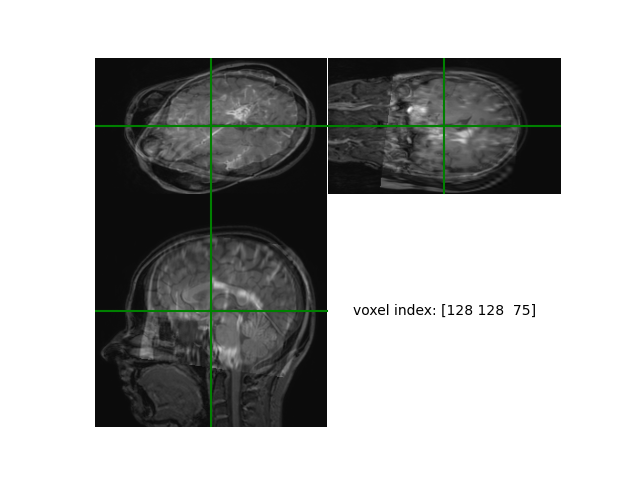

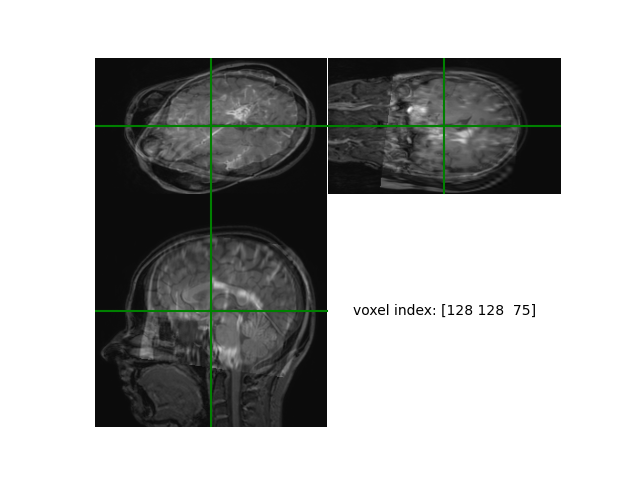

In [22]:
Viewer( T2_data_resampled / T2_data_resampled.max() + T1_data / T1_data.max() )

### Task 2: Compute and visualize the joint histogram

Compute the joint histogram 
$$ 
\mathbf{H} = 
\begin{pmatrix}
h_{1,1} & ... & h_{1,B} \\
\vdots & ... & \vdots \\
h_{B,1} & ... & h_{B,B} \\
\end{pmatrix} 
$$
of the T1-weighted scan and the resampled T2-weighted scan you just created, using $B=32$ bins. In order not to let the registration process be dominated by the (extremely numerous) background voxels, ignore all voxels with an intensity lower than 10 in either image when computing the histogram. Visualize the joint histogram using a 3D bar plot, and label the axes.

> ***Hints:***
>
> - To compute a 2D histogram, you can use the function
>
>           np.histogram2d(x,y,bins,range)
> 
> - A 3D bar plot can be created as follows:
>
>           fig, ax = plt.subplots( subplot_kw=dict( projection='3d') )
>           plt.bar3d(xpos, ypos, zpos, dx, dy, dz)
>
>   where xpos, ypos, and zpos are the anchor points of the bars and dx, dy, and dz are the dimensions of the bars.
>
> - A useful "trick" to verify that your axes are labeled correctly, is to use a different number of bins for the two scans.
>

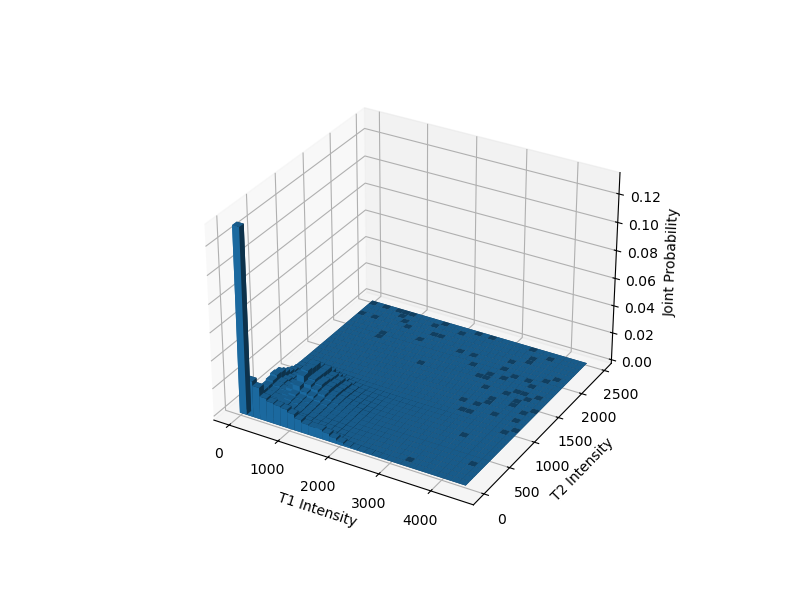

In [23]:
B = 32
threshold = 10


#Finding the joint histogram
H, xedges, yedges = np.histogram2d( T1_data.flatten(), T2_data_resampled.flatten(), bins=B, range=[[threshold, np.max(T1_data)], [threshold, np.max(T2_data_resampled)]] )
jointProb = H / np.sum(H)

#Taken inspiration from https://stackoverflow.com/questions/52385299/plot-a-3d-bar-histogram
xpos, ypos = np.meshgrid(xedges[:-1]+xedges[1:], yedges[:-1]+yedges[1:]) - (xedges[1]-xedges[0])


xpos = xpos.flatten()*1./2 #take times 1/2 to get to the center of the bin
ypos = ypos.flatten()*1./2
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = np.zeros_like(xpos)


dx = xedges [1] - xedges [0]
dy = yedges [1] - yedges [0]
dz = jointProb.ravel()

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(8,6))
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, shade=True)

ax.set_xlabel('T1 Intensity')
ax.set_ylabel('T2 Intensity')
ax.set_zlabel('Joint Probability')
plt.show()




### Task 3: Compute the mutual information between the two images
Write a function that takes two image volumes defined on the same image grid as input, and returns the mutual information between the two images:

$$ 
MI = H_{F} + H_{M} - H_{F,M} 
$$
with
$$ 
H_{F,M} = - \sum_{f=1}^{B} \sum_{m=1}^{B} p_{f,m} \log(p_{f,m}),
$$
$$ 
H_{F} = - \sum_{f=1}^{B} p_{f} \log(p_{f}), 
$$
and
$$
H_{M} = - \sum_{m=1}^{B} p_{m} \log(p_{m})
.
$$

Your function should make use of the joint histogram computed as in the previous task (i.e., using $B=32$ bins and ignoring all voxels with intensity lower than 10).

Use your new function to compute the mutual information between the T1-weighted image and the resampled T2-weighted image.

> ***Hints:***
>
> - To avoid numerical errors when one of the bins is empty and 0*log(0)=0 is therefore computed numerically, you can add a tiny value (e.g., 1e-12) to each histogram bin

In [24]:
def mutual_information(B, T1_data, T2_data_resampled, threshold):
    #Finding the joint histogram
    H, x, y = np.histogram2d( T1_data.flatten(), T2_data_resampled.flatten(), bins=B, range=[[threshold, np.max(T1_data)], [threshold, np.max(T2_data_resampled)]] )
    jointProb = H / np.sum(H)
    H_FM = -np.sum( jointProb * np.log( jointProb + 1e-12 ) ) #adding a small number to avoid log(0)

    #finding the histogram for T1
    H_T1, x = np.histogram( T1_data.flatten(), bins=B, range=(threshold, np.max(T1_data)) )
    p_F = H_T1 / np.sum(H_T1)
    H_F = -np.sum( p_F * np.log( p_F + 1e-12 ) ) #adding a small number to avoid log(0)

    #finding the histogram for T2
    H_T2, x = np.histogram( T2_data_resampled.flatten(), bins=B, range=(threshold, np.max(T2_data_resampled)) )
    p_M = H_T2 / np.sum(H_T2)
    H_M = -np.sum( p_M * np.log( p_M + 1e-12 ) ) #adding a small number to avoid log(0)

    #Calculating the mutual information
    MI= H_F + H_M - H_FM

    return MI


    

In [25]:
MI = mutual_information(B, T1_data, T2_data_resampled, threshold)
print(MI)


-0.15204493004060815


### Task 4: Evaluate the mutual information across a range of rotation angles

Implement a grid search over a range of rotation angles, with the goal of identifying the angle with approximately the highest mutual information (i.e., where the registration is best). Make an educated guess of a suitable range by visually inspecting the images (or by simply trying a few rotation angles and inspecting the result), and then define a list of candidate angles at intervals of e.g., 5° apart:

       a = np.arange(a_{lowest}, a_{highest}, 5)

Loop over all candidate rotation angles, each time (1) creating a corresponding rotation matrix $\mathbf{R}$; (2) resampling the T2-weighted volume accordingly; (3) calculating the mutual information with the function you created above; and (4) storing the mutual information value.

> ***Hint:***
> 
> - A 3D rotation matrix can be parameterized as follows:
> 
> $$\mathbf{R} = \mathbf{R}_{z} \mathbf{R}_{y} \mathbf{R_{x}},$$ 
> where
>
> $$
\mathbf{R}_z = 
\begin{pmatrix} 
 cos( \theta_z ) & -sin( \theta_z ) & 0 & \\
 sin( \theta_z ) & cos( \theta_z ) & 0 & \\
 0 & 0 & 1 & \\
\end{pmatrix}
$$
> implements a rotation around the z-axis in world coordinates;
> $$
\mathbf{R}_y = 
\begin{pmatrix} 
 cos( \theta_y ) & -sin( \theta_y ) & 0 & \\
 0 & 1 & 0 & \\
 sin( \theta_y ) & cos( \theta_y ) & 0 & \\
\end{pmatrix}
$$
> is a rotation around the y-axis;
and
> $$
\mathbf{R}_x = 
\begin{pmatrix} 
 1 & 0 & 0 & \\
 cos( \theta_x ) & -sin( \theta_x ) & 0 & \\
 sin( \theta_x ) & cos( \theta_x ) & 0 & \\
\end{pmatrix}
$$
> rotates around the x-axis.
>
>
> - If you didn't figure out in Task 1 which axis the T2-weighted volume was rotated around, you can try rotating around each axis (one at a time) to see the effect of each transformation. Once you've determined the correct rotation axis, the rotation angles around the other axes should be clamped to zero.


In [26]:
print(range(30))

range(0, 30)



Best rotation angle: 45° with MI = 0.0142


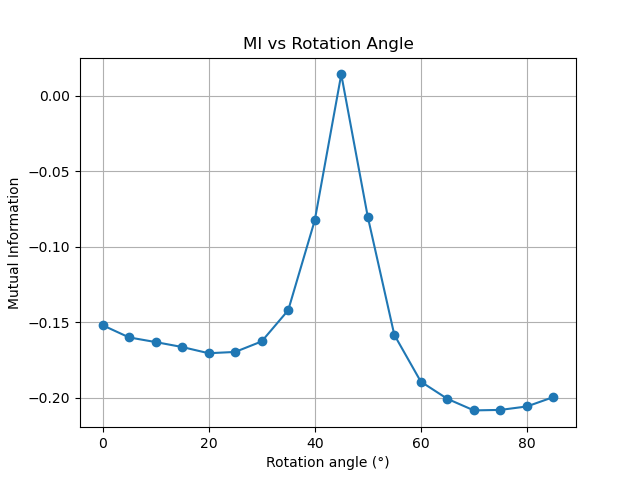

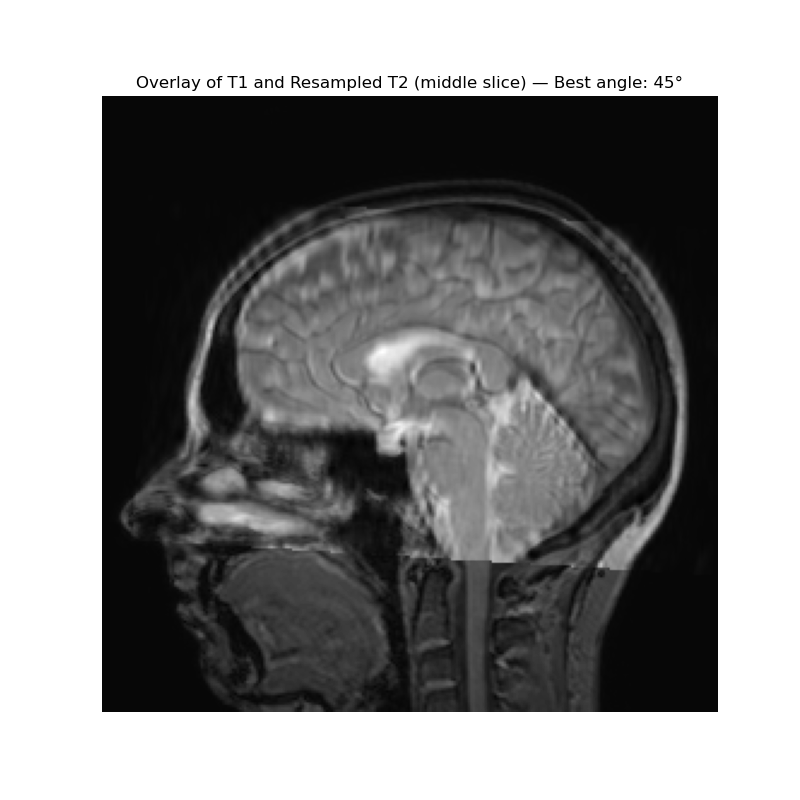

In [27]:
a = np.arange(0,90, 5)
mi_values = []
resampled_images = []


for i in range(len(a)):
    #Creating the rotation matrix R
    R_z = np.array( [ [ np.cos(np.deg2rad(a[i])), -np.sin(np.deg2rad(a[i])), 0 ],
                    [ np.sin(np.deg2rad(a[i])),  np.cos(np.deg2rad(a[i])), 0 ],
                    [ 0, 0, 1 ] ] )

    R_y = np.array( [ [ np.cos(np.deg2rad(a[i])),0,  -np.sin(np.deg2rad(a[i])),  ],
                    [ 0,  1, 0 ],
                    [ np.sin(np.deg2rad(a[i])),0,  np.cos(np.deg2rad(a[i])) ] ] )
    R_x = np.array( [ [ 1, 0, 0 ],
                    [ 0, np.cos(np.deg2rad(a[i])), -np.sin(np.deg2rad(a[i])) ],
                    [ 0, np.sin(np.deg2rad(a[i])),  np.cos(np.deg2rad(a[i])) ] ] )   

    #By inspecting found out I only need to rotate around z
    R = R_z #R_z @ R_y @ R_x
    
    #Resample the T2 data
    #Creating the M matrix from the book where it says A=R
    M = np.eye(4)
    M[:3,:3] = R 

    #then we do like last time
    #Creating the V_stack to
    V1,V2,V3 = np.meshgrid( np.arange( T1_data.shape[0] ), np.arange( T1_data.shape[1] ), np.arange( T1_data.shape[2] ), indexing='ij' )
    V_stack = []
    V_stack.append( V1.flatten() )
    V_stack.append( V2.flatten() )
    V_stack.append( V3.flatten() )
    V_stack.append( np.ones( V1.size ) )
    V_stack = np.array(V_stack)

    #do the rotation
    V_T2_space = np.linalg.inv( A_T2 ) @ M @ A_T1 @ V_stack #With the M for ratation
    
    #Now we interpolate the T2 data to the T1 grid
    V_T2_in_T1_space_intensity = scipy.ndimage.map_coordinates( T2_data, V_T2_space[:3,:] )
    V_T2_in_T1_space_intensity = V_T2_in_T1_space_intensity.reshape( T1_data.shape )
    T2_data_resampled_a = V_T2_in_T1_space_intensity
    resampled_images.append(T2_data_resampled_a)

    #Calculating the MI
    mi = mutual_information(32, T1_data, T2_data_resampled_a, 10)
    mi_values.append(mi)

    #Viewer( T2_data_resampled_a / T2_data_resampled_a.max() + T1_data / T1_data.max() )

    

# Find best angle
best_idx = np.argmax(mi_values)
best_angle = a[best_idx]
print(f"\nBest rotation angle: {best_angle}° with MI = {mi_values[best_idx]:.4f}")

# --- Plot MI vs angles ---
plt.figure()
plt.plot(a, mi_values, '-o')
plt.xlabel("Rotation angle (°)")
plt.ylabel("Mutual Information")
plt.title("MI vs Rotation Angle")
plt.grid(True)
plt.show()

# --- Plot overlay for best angle ---
best_resampled = resampled_images[best_idx]
z = T1_data.shape[2] // 2  # Middle slice
overlay_best = (best_resampled[:, :, z] / best_resampled.max()) + (T1_data[:, :, z] / T1_data.max())

plt.figure(figsize=(8, 8))
plt.imshow(overlay_best.T, cmap='gray', origin='lower')
plt.title(f'Overlay of T1 and Resampled T2 (middle slice) — Best angle: {best_angle}°')
plt.axis('off')
plt.show()

#Viewer( T2_data_resampled / T2_data_resampled.max() + T1_data / T1_data.max() )
    
    
    




    



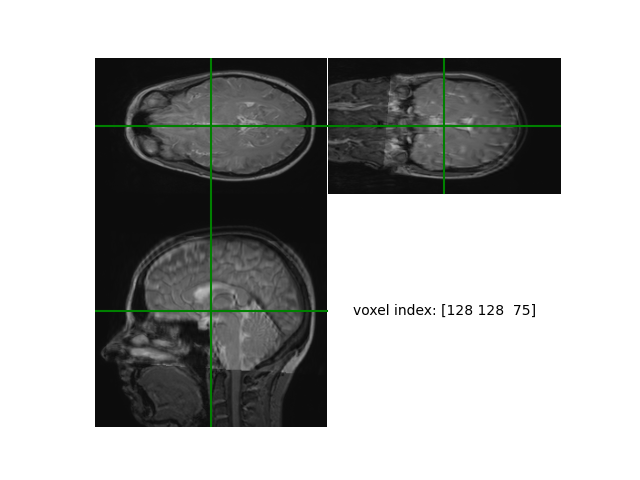

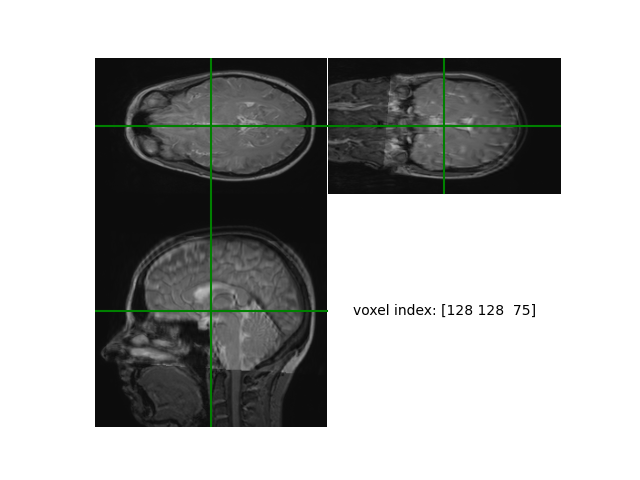

In [28]:
Viewer( best_resampled / best_resampled.max() + T1_data / T1_data.max() )

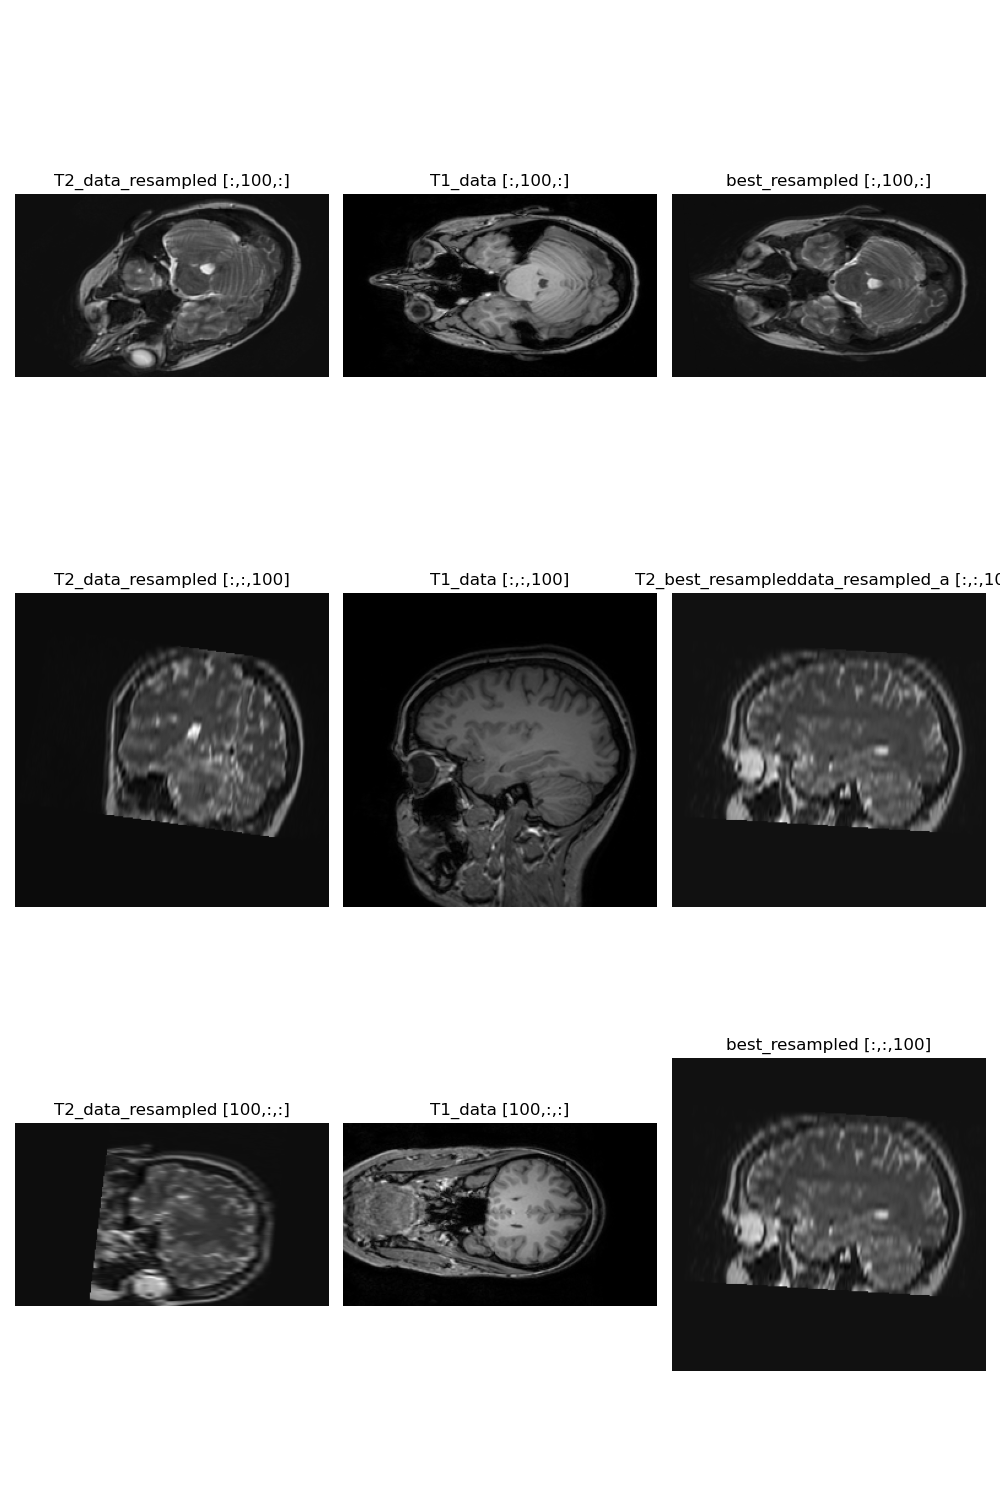

In [29]:
fig, axes = plt.subplots(3, 3, figsize=(10, 15))

# Y-slice (x, z) at y=100
axes[0, 0].imshow(T2_data_resampled[:,100,:].T, cmap='gray', origin='lower')
axes[0, 0].set_title('T2_data_resampled [:,100,:]')
axes[0, 1].imshow(T1_data[:,100,:].T, cmap='gray', origin='lower')
axes[0, 1].set_title('T1_data [:,100,:]')
axes[0, 2].imshow(best_resampled[:,100,:].T, cmap='gray', origin='lower')
axes[0, 2].set_title('best_resampled [:,100,:]')


# Z-slice (x, y) at z=100
axes[1, 0].imshow(T2_data_resampled[:,:,100].T, cmap='gray', origin='lower')
axes[1, 0].set_title('T2_data_resampled [:,:,100]')
axes[1, 1].imshow(T1_data[:,:,100].T, cmap='gray', origin='lower')
axes[1, 1].set_title('T1_data [:,:,100]')
axes[1, 2].imshow(best_resampled[:,:,100].T, cmap='gray', origin='lower')
axes[1, 2].set_title('T2_best_resampleddata_resampled_a [:,:,100]')

# X-slice (y, z) at x=100
axes[2, 0].imshow(T2_data_resampled[100,:,:].T, cmap='gray', origin='lower')
axes[2, 0].set_title('T2_data_resampled [100,:,:]')
axes[2, 1].imshow(T1_data[100,:,:].T, cmap='gray', origin='lower')
axes[2, 1].set_title('T1_data [100,:,:]')
axes[2, 2].imshow(best_resampled[:,:,100].T, cmap='gray', origin='lower')
axes[2, 2].set_title('best_resampled [:,:,100]')

for ax_row in axes:
    for ax in ax_row:
        ax.axis('off')

plt.tight_layout()
plt.show()

### Task 5: Perform automatic registration

Plot the negative mutual information, i.e. the energy function $E(\mathbf{w})= H_{F,M}-H_{F}-H_{M}$ for every angle in your grid search space. Select the one with the lowest energy (i.e., the best angle for registration) and transform the T2-weighted volume according to this angle.

Use the Viewer() function to visualize your registration result.

In [30]:
#Creating the energy function
def energy(B, T1_data, T2_data_resampled, threshold):
    #Finding the joint histogram
    H, x, y = np.histogram2d( T1_data.flatten(), T2_data_resampled.flatten(), bins=B, range=[[threshold, np.max(T1_data)], [threshold, np.max(T2_data_resampled)]] )
    jointProb = H / np.sum(H)
    H_FM = -np.sum( jointProb * np.log( jointProb + 1e-12 ) ) #adding a small number to avoid log(0)

    #finding the histogram for T1
    H_T1, x = np.histogram( T1_data.flatten(), bins=B, range=(threshold, np.max(T1_data)) )
    p_F = H_T1 / np.sum(H_T1)
    H_F = -np.sum( p_F * np.log( p_F + 1e-12 ) ) #adding a small number to avoid log(0)

    #finding the histogram for T2
    H_T2, x = np.histogram( T2_data_resampled.flatten(), bins=B, range=(threshold, np.max(T2_data_resampled)) )
    p_M = H_T2 / np.sum(H_T2)
    H_M = -np.sum( p_M * np.log( p_M + 1e-12 ) ) #adding a small number to avoid log(0)

    #Calculating the mutual information
    E_w= H_FM - H_F - H_M 

    return E_w


    


Best rotation angle: 45° with MI = -0.0142


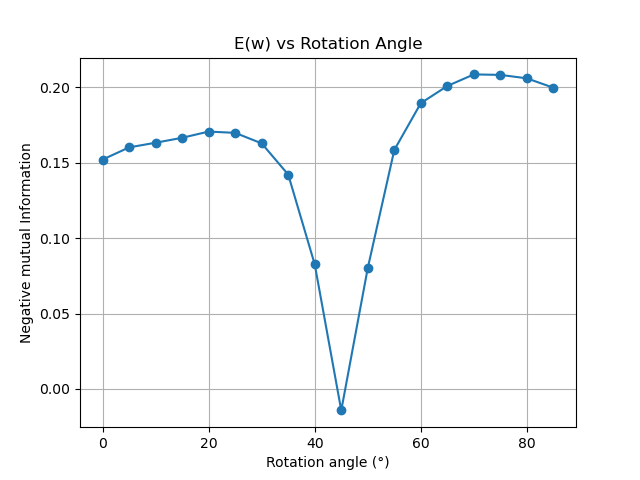

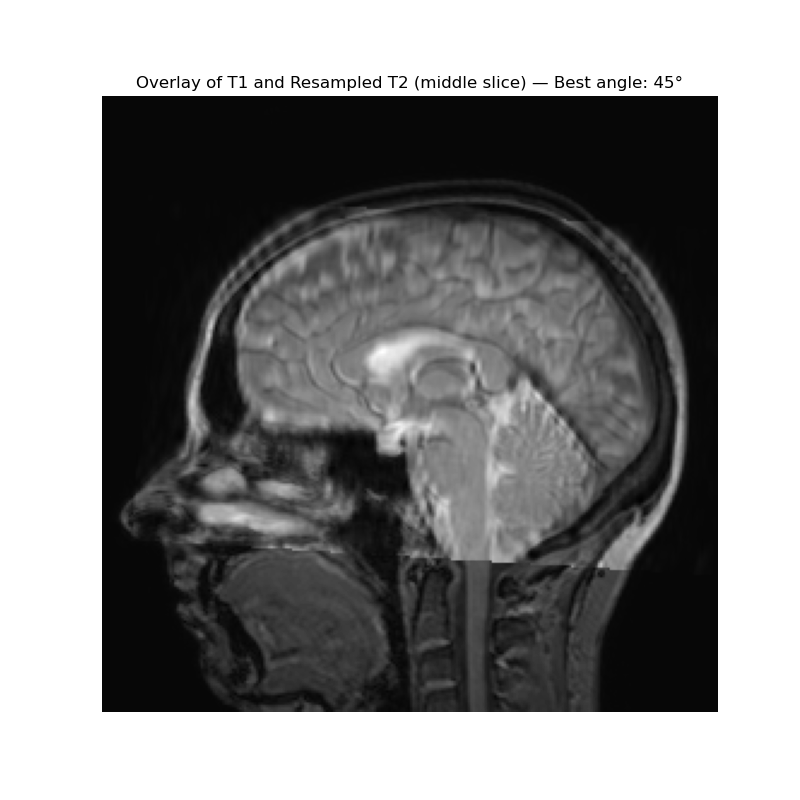

In [31]:
a = np.arange(0,90, 5)
ew_values = []
resampled_images = []


for i in range(len(a)):
    #Creating the rotation matrix R
    R_z = np.array( [ [ np.cos(np.deg2rad(a[i])), -np.sin(np.deg2rad(a[i])), 0 ],
                    [ np.sin(np.deg2rad(a[i])),  np.cos(np.deg2rad(a[i])), 0 ],
                    [ 0, 0, 1 ] ] )

    R_y = np.array( [ [ np.cos(np.deg2rad(a[i])),0,  -np.sin(np.deg2rad(a[i])),  ],
                    [ 0,  1, 0 ],
                    [ np.sin(np.deg2rad(a[i])),0,  np.cos(np.deg2rad(a[i])) ] ] )
    R_x = np.array( [ [ 1, 0, 0 ],
                    [ 0, np.cos(np.deg2rad(a[i])), -np.sin(np.deg2rad(a[i])) ],
                    [ 0, np.sin(np.deg2rad(a[i])),  np.cos(np.deg2rad(a[i])) ] ] )   

    #By inspecting found out I only need to rotate around z
    R = R_z #R_z @ R_y @ R_x
    
    #Resample the T2 data
    #Creating the M matrix from the book where it says A=R
    M = np.eye(4)
    M[:3,:3] = R 

    #then we do like last time
    #Creating the V_stack to
    V1,V2,V3 = np.meshgrid( np.arange( T1_data.shape[0] ), np.arange( T1_data.shape[1] ), np.arange( T1_data.shape[2] ), indexing='ij' )
    V_stack = []
    V_stack.append( V1.flatten() )
    V_stack.append( V2.flatten() )
    V_stack.append( V3.flatten() )
    V_stack.append( np.ones( V1.size ) )
    V_stack = np.array(V_stack)

    #do the rotation
    V_T2_space = np.linalg.inv( A_T2 ) @ M @ A_T1 @ V_stack #With the M for ratation
    
    #Now we interpolate the T2 data to the T1 grid
    V_T2_in_T1_space_intensity = scipy.ndimage.map_coordinates( T2_data, V_T2_space[:3,:] )
    V_T2_in_T1_space_intensity = V_T2_in_T1_space_intensity.reshape( T1_data.shape )
    T2_data_resampled_a = V_T2_in_T1_space_intensity
    resampled_images.append(T2_data_resampled_a)

    #Calculating the MI
    ew = energy(32, T1_data, T2_data_resampled_a, 10)
    ew_values.append(ew)

    #Viewer( T2_data_resampled_a / T2_data_resampled_a.max() + T1_data / T1_data.max() )

    

# Find best angle
best_idx = np.argmin(ew_values)
best_angle = a[best_idx]
print(f"\nBest rotation angle: {best_angle}° with MI = {ew_values[best_idx]:.4f}")

# --- Plot MI vs angles ---
plt.figure()
plt.plot(a, ew_values, '-o')
plt.xlabel("Rotation angle (°)")
plt.ylabel("Negative mutual Information")
plt.title("E(w) vs Rotation Angle")
plt.grid(True)
plt.show()

# --- Plot overlay for best angle ---
best_resampled_ew = resampled_images[best_idx]
z = T1_data.shape[2] // 2  # Middle slice
overlay_best_ew = (best_resampled_ew[:, :, z] / best_resampled_ew.max()) + (T1_data[:, :, z] / T1_data.max())

plt.figure(figsize=(8, 8))
plt.imshow(overlay_best_ew.T, cmap='gray', origin='lower')
plt.title(f'Overlay of T1 and Resampled T2 (middle slice) — Best angle: {best_angle}°')
plt.axis('off')
plt.show()




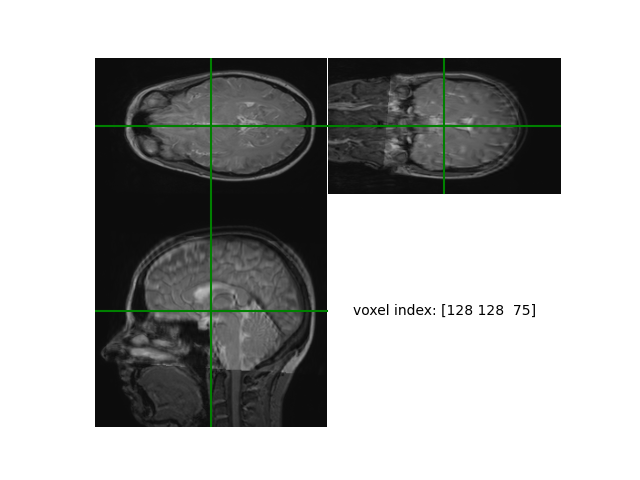

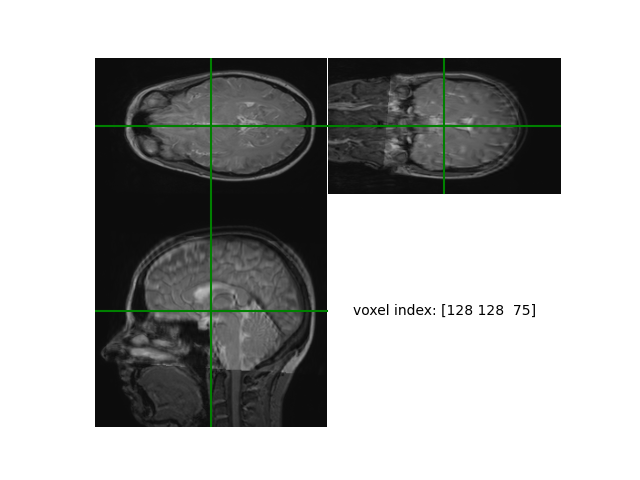

In [32]:
Viewer( best_resampled_ew / best_resampled_ew.max() + T1_data / T1_data.max() )

/var/folders/hl/qy0plgj51wn6xpjv1k7_bzm80000gn/T/ipykernel_75870/2427816626.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(3, 4, figsize=(14, 12))


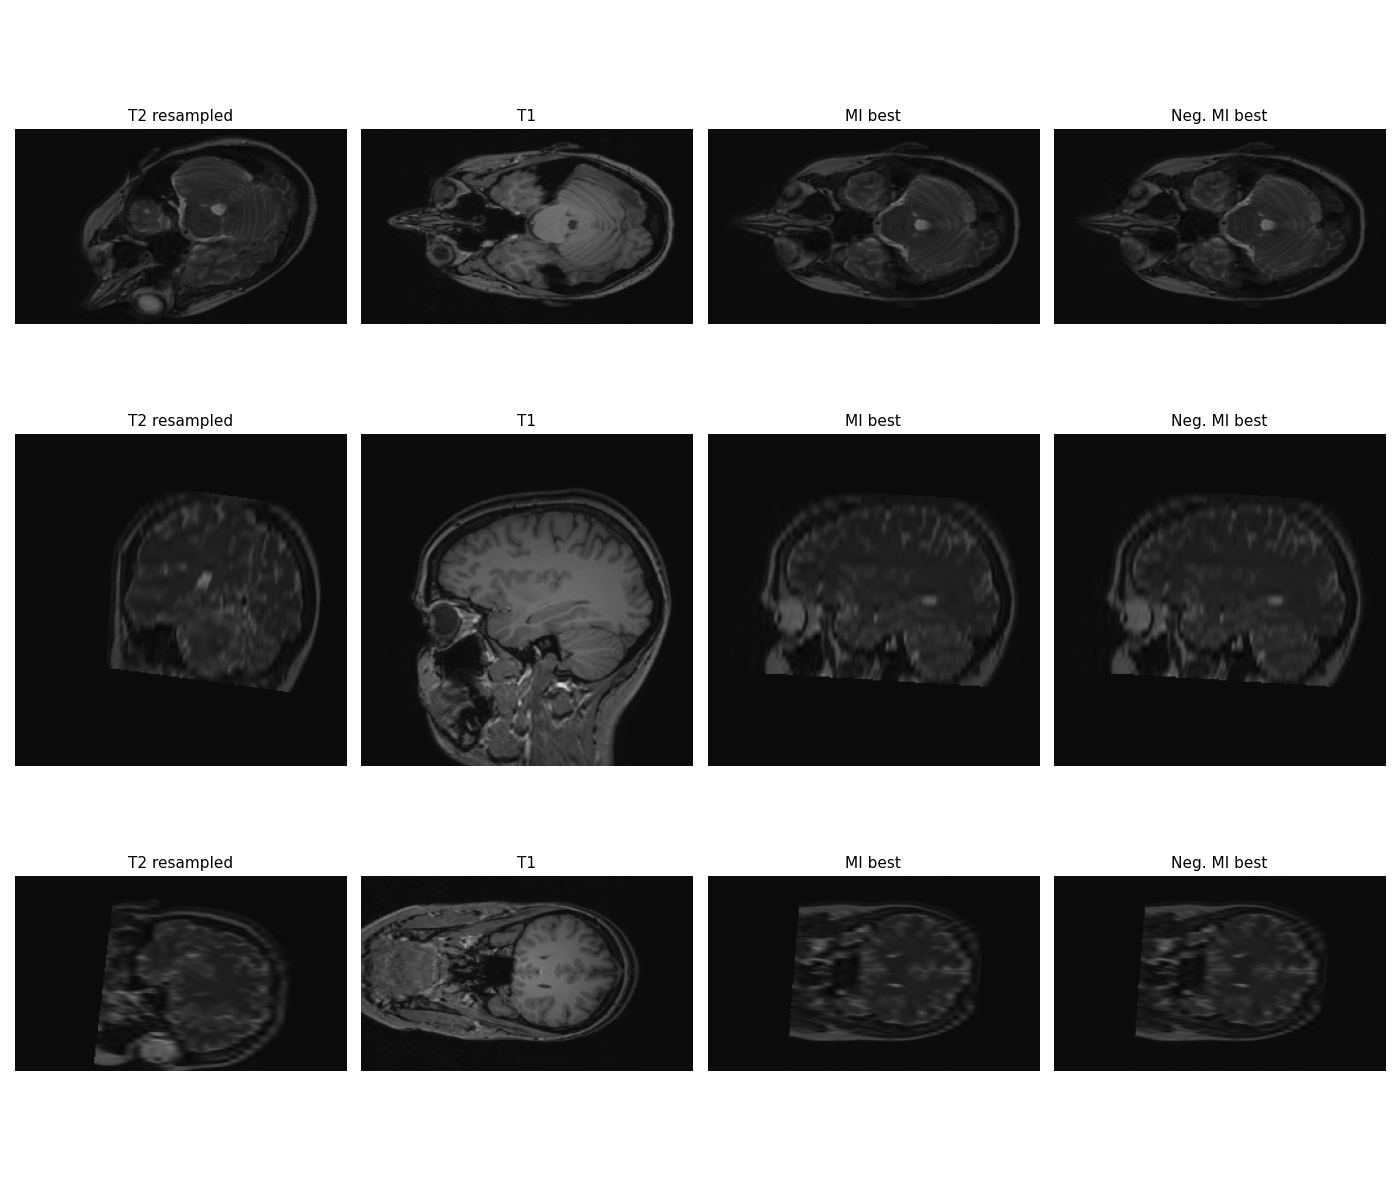

In [33]:
fig, axes = plt.subplots(3, 4, figsize=(14, 12))

slice_idx = 100
vmin = min(T1_data.min(), T2_data_resampled.min(), best_resampled.min(), best_resampled_ew.min())
vmax = max(T1_data.max(), T2_data_resampled.max(), best_resampled.max(), best_resampled_ew.max())

titles = [
    ["T2 resampled", "T1", "MI best", "Neg. MI best"],
    ["T2 resampled", "T1", "MI best", "Neg. MI best"],
    ["T2 resampled", "T1", "MI best", "Neg. MI best"]
]
row_labels = ["Y-slice (x,z)", "Z-slice (x,y)", "X-slice (y,z)"]

# Y-slice (x, z) at y=slice_idx
axes[0, 0].imshow(T2_data_resampled[:,slice_idx,:].T, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
axes[0, 1].imshow(T1_data[:,slice_idx,:].T, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
axes[0, 2].imshow(best_resampled[:,slice_idx,:].T, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
axes[0, 3].imshow(best_resampled_ew[:,slice_idx,:].T, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)

# Z-slice (x, y) at z=slice_idx
axes[1, 0].imshow(T2_data_resampled[:,:,slice_idx].T, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
axes[1, 1].imshow(T1_data[:,:,slice_idx].T, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
axes[1, 2].imshow(best_resampled[:,:,slice_idx].T, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
axes[1, 3].imshow(best_resampled_ew[:,:,slice_idx].T, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)

# X-slice (y, z) at x=slice_idx
axes[2, 0].imshow(T2_data_resampled[slice_idx,:,:].T, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
axes[2, 1].imshow(T1_data[slice_idx,:,:].T, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
axes[2, 2].imshow(best_resampled[slice_idx,:,:].T, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
axes[2, 3].imshow(best_resampled_ew[slice_idx,:,:].T, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)

# Set titles and row labels
for i in range(3):
    for j in range(4):
        axes[i, j].set_title(titles[i][j], fontsize=11)
    axes[i, 0].set_ylabel(row_labels[i], fontsize=12)

# Remove axes
for ax_row in axes:
    for ax in ax_row:
        ax.axis('off')

plt.tight_layout()
plt.show()

### Task 6: Compare the joint histogram before and after registration

Visualize the joint histogram after registration. Compare the result to your initial joint histogram (i.e., before registration) and discuss your findings in your report.

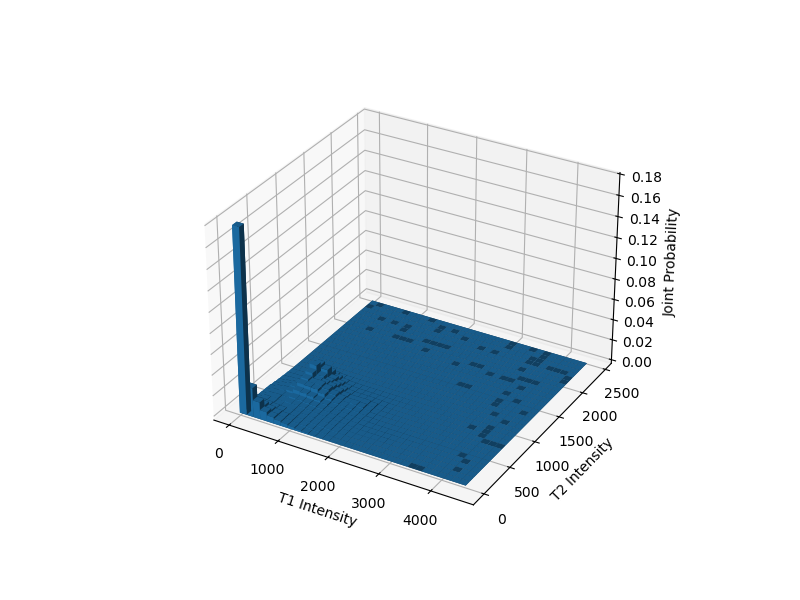

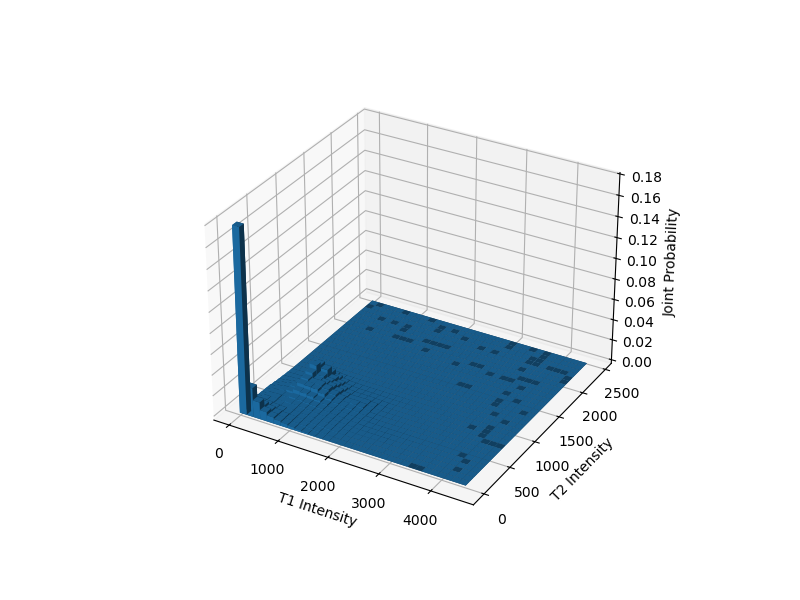

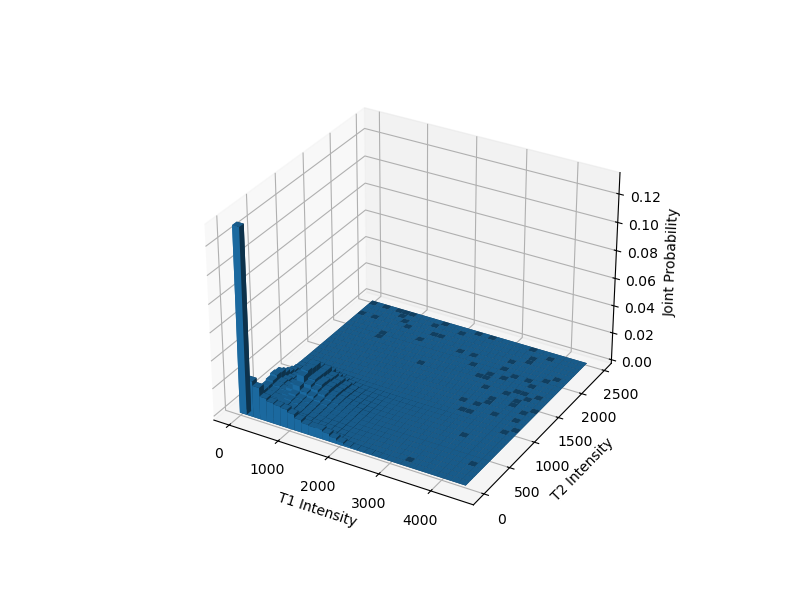

In [34]:
#finding the joint histogram for the MI
B = 32
threshold = 10


#Finding the joint histogram
H, xedges, yedges = np.histogram2d( T1_data.flatten(), best_resampled.flatten(), bins=B, range=[[threshold, np.max(T1_data)], [threshold, np.max(best_resampled)]] )
jointProb = H / np.sum(H)

#Taken inspiration from https://stackoverflow.com/questions/52385299/plot-a-3d-bar-histogram
xpos, ypos = np.meshgrid(xedges[:-1]+xedges[1:], yedges[:-1]+yedges[1:]) - (xedges[1]-xedges[0])


xpos = xpos.flatten()*1./2 #take times 1/2 to get to the center of the bin
ypos = ypos.flatten()*1./2
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = np.zeros_like(xpos)


dx = xedges [1] - xedges [0]
dy = yedges [1] - yedges [0]
dz = jointProb.ravel()

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(8,6))
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, shade=True)

ax.set_xlabel('T1 Intensity')
ax.set_ylabel('T2 Intensity')
ax.set_zlabel('Joint Probability')
plt.show()

#Finding for the neg MI
B = 32
threshold = 10


#Finding the joint histogram
H, xedges, yedges = np.histogram2d( T1_data.flatten(), best_resampled_ew.flatten(), bins=B, range=[[threshold, np.max(T1_data)], [threshold, np.max(best_resampled_ew)]] )
jointProb = H / np.sum(H)

#Taken inspiration from https://stackoverflow.com/questions/52385299/plot-a-3d-bar-histogram
xpos, ypos = np.meshgrid(xedges[:-1]+xedges[1:], yedges[:-1]+yedges[1:]) - (xedges[1]-xedges[0])


xpos = xpos.flatten()*1./2 #take times 1/2 to get to the center of the bin
ypos = ypos.flatten()*1./2
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = np.zeros_like(xpos)


dx = xedges [1] - xedges [0]
dy = yedges [1] - yedges [0]
dz = jointProb.ravel()

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(8,6))
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, shade=True)

ax.set_xlabel('T1 Intensity')
ax.set_ylabel('T2 Intensity')
ax.set_zlabel('Joint Probability')
plt.show()

B = 32
threshold = 10


#Finding the joint histogram
H, xedges, yedges = np.histogram2d( T1_data.flatten(), T2_data_resampled.flatten(), bins=B, range=[[threshold, np.max(T1_data)], [threshold, np.max(T2_data_resampled)]] )
jointProb = H / np.sum(H)

#Taken inspiration from https://stackoverflow.com/questions/52385299/plot-a-3d-bar-histogram
xpos, ypos = np.meshgrid(xedges[:-1]+xedges[1:], yedges[:-1]+yedges[1:]) - (xedges[1]-xedges[0])


xpos = xpos.flatten()*1./2 #take times 1/2 to get to the center of the bin
ypos = ypos.flatten()*1./2
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = np.zeros_like(xpos)


dx = xedges [1] - xedges [0]
dy = yedges [1] - yedges [0]
dz = jointProb.ravel()

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(8,6))
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, shade=True)

ax.set_xlabel('T1 Intensity')
ax.set_ylabel('T2 Intensity')
ax.set_zlabel('Joint Probability')
plt.show()






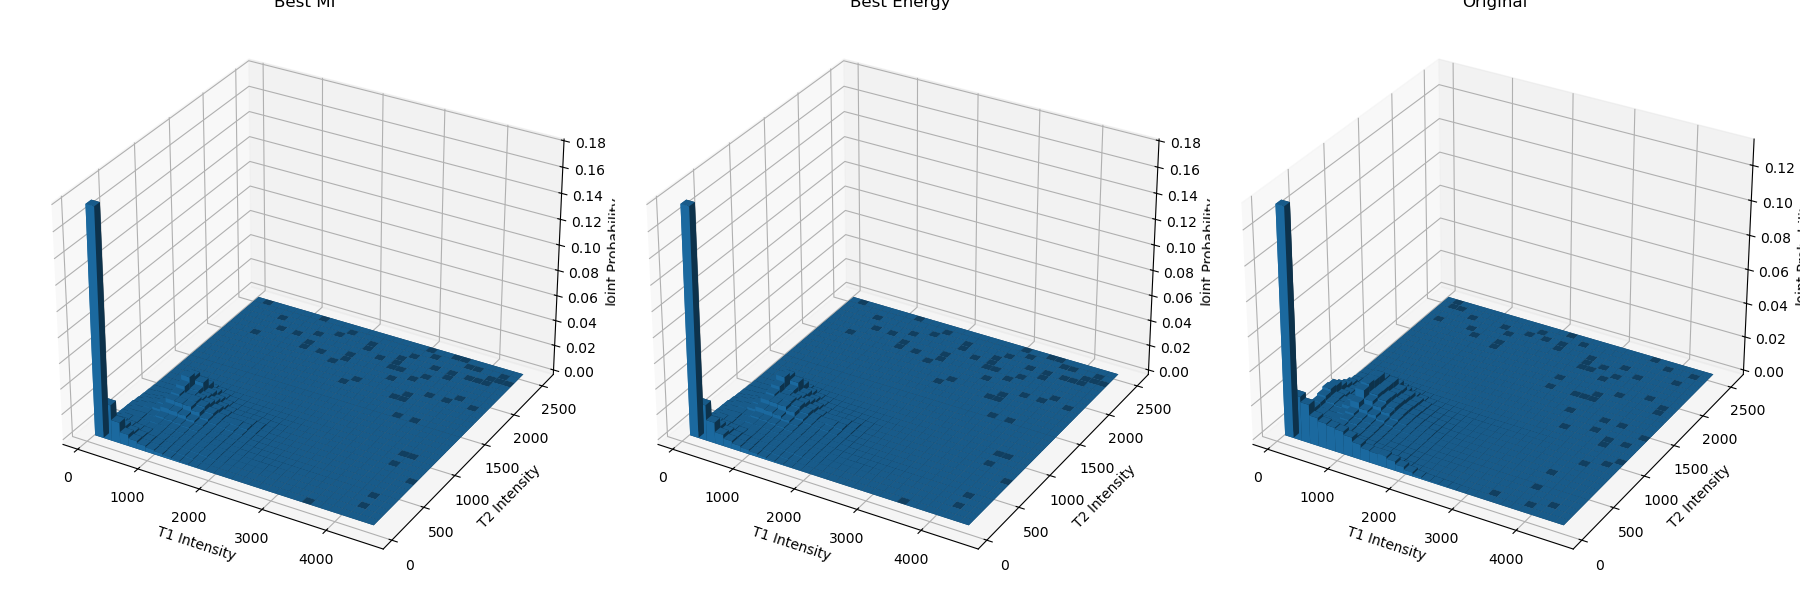

In [35]:
import matplotlib.pyplot as plt
import numpy as np

def plot_joint_histogram(T1, T2, title, B=32, threshold=10, ax=None):
    H, xedges, yedges = np.histogram2d(
        T1.flatten(),
        T2.flatten(),
        bins=B,
        range=[[threshold, np.max(T1)], [threshold, np.max(T2)]]
    )
    jointProb = H / np.sum(H)

    xpos, ypos = np.meshgrid(
        xedges[:-1] + xedges[1:],
        yedges[:-1] + yedges[1:]
    )
    xpos = (xpos.flatten() * 0.5)
    ypos = (ypos.flatten() * 0.5)
    xpos = xpos.ravel()
    ypos = ypos.ravel()
    zpos = np.zeros_like(xpos)

    dx = (xedges[1] - xedges[0]) * np.ones_like(zpos)
    dy = (yedges[1] - yedges[0]) * np.ones_like(zpos)
    dz = jointProb.ravel()

    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, shade=True)
    ax.set_xlabel('T1 Intensity')
    ax.set_ylabel('T2 Intensity')
    ax.set_zlabel('Joint Probability')
    ax.set_title(title)

# --- Create figure with 3 subplots ---
fig = plt.figure(figsize=(18, 6))

ax1 = fig.add_subplot(131, projection='3d')
plot_joint_histogram(T1_data, best_resampled, "Best MI", ax=ax1)

ax2 = fig.add_subplot(132, projection='3d')
plot_joint_histogram(T1_data, best_resampled_ew, "Best Energy", ax=ax2)

ax3 = fig.add_subplot(133, projection='3d')
plot_joint_histogram(T1_data, T2_data_resampled, "Original", ax=ax3)

plt.tight_layout()
plt.show()


### Additional task for the enthusiastic student: Compare the MI obtained with landmark-based and intensity-based registration

Perform landmark-based registration between the T1-weighted and T2-weighted volumes instead, just like you did in the last exercise. For the resulting registration, view your results with the Viewer() class; visualize the joint histogram, and calculate the mutual information. 

Compare the results with those obtained using mutual information, and discuss.

> ***Hint:***
> - You can reuse the landmarks that you collected in the landmark-based registration exercise, as these were defined in voxel space. 

In [38]:
#Affine registration
#Stacking the chosen landmarks in one matrix for each image
LM_t1 = np.vstack([
    [37, 110, 79, 1],    # Nose ridge
    [240, 110, 78, 1],   # Back skull
    [144, 110, 131, 1],  # Right side skull
    [144, 110, 20, 1],   # Left side skull
    [144, 198, 75, 1]   # Top of brain/skull
])

LM_t2 = np.vstack([
    [125, 231, 8, 1],    # Nose ridge
    [137, 20, 8, 1],     # Back skull
    [55, 116, 8, 1],     # Right side skull 
    [206, 116, 8, 1],    # left side skull
    [128, 116, 25, 1]    # Top of brain/skull
])

#Converting the landmarks to world coordinates
T1_world = (A_T1 @ LM_t1.T).T[:, :3]
T2_world = (A_T2 @ LM_t2.T).T[:, :3]

#Building the X matrix for the equation 2.8
X = np.hstack([T1_world, np.ones((T1_world.shape[0], 1))])  # (N, 4)

#Doing Least squares to find A
A = np.linalg.inv(X.T @ X) @ X.T @ T2_world  

# Build full affine matrix M
M = np.eye(4)
M[:3, :3] = A[:3, :].T   # rotation+scaling
M[:3, 3] = A[3, :]       # translation
mapping_matrix = np.linalg.inv(A_T2) @ M @ A_T1

V1,V2,V3 = np.meshgrid( np.arange( T1_data.shape[0] ), np.arange( T1_data.shape[1] ), np.arange( T1_data.shape[2] ), indexing='ij' )
V_stack = []
V_stack.append( V1.flatten() )
V_stack.append( V2.flatten() )
V_stack.append( V3.flatten() )
V_stack.append( np.ones( V1.size ) )
V_stack = np.array(V_stack)

#Converting the points to T2 space
V_T2_space = mapping_matrix @ V_stack

#Now we interpolate the T2 data to the T1 grid
V_T2_in_T1_space_intensity = scipy.ndimage.map_coordinates( T2_data, V_T2_space[:3,:] )
affine_reg = V_T2_in_T1_space_intensity.reshape( T1_data.shape )

#Rigid registration
def rigid_registration(P, Q):
    centroid_P = np.mean(P, axis=0)
    centroid_Q = np.mean(Q, axis=0)

    P_centered = P - centroid_P
    Q_centered = Q - centroid_Q

    H = P_centered.T @ Q_centered
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T

    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = Vt.T @ U.T

    t = centroid_Q - R @ centroid_P
    return R, t

R, t = rigid_registration(T1_world, T2_world)

# Step 3: Build transformation matrix
M = np.eye(4)
M[:3, :3] = R
M[:3, 3] = t

# Step 4: Map T1 voxels to T2 voxels
mapping_matrix = np.linalg.inv(A_T2) @ M @ A_T1

V1, V2, V3 = np.meshgrid(np.arange(T1_data.shape[0]),
                          np.arange(T1_data.shape[1]),
                          np.arange(T1_data.shape[2]),
                          indexing='ij')

V_T1 = np.column_stack([V1.flatten(), V2.flatten(), V3.flatten(), np.ones(len(V3.flatten()))])
V_stack = V_T1.T

V_T2_space = mapping_matrix @ V_stack

# Step 5: Interpolation
V_T2_in_T1_space_intensity = scipy.ndimage.map_coordinates( T2_data, V_T2_space[:3,:],order=3 )
Rigid_reg = V_T2_in_T1_space_intensity.reshape( T1_data.shape )




In [45]:
#Comaparing the Registrations
MI_affine = mutual_information(B, T1_data, affine_reg, threshold)
MI_rigid = mutual_information(B, T1_data, Rigid_reg, threshold)
MI_MI = mutual_information(B, T1_data, best_resampled, threshold)
MI_EW = energy(B, T1_data, best_resampled_ew, threshold)
print(f"Mutual Information after Affine Registration: {MI_affine:.4f}")
print(f"Mutual Information after Rigid Registration: {MI_rigid:.4f}")
print(f"Mutual Information after Rotation: {MI_MI:.4f}")
print(f"Mutual Information after Negative MI: {MI_EW:.4f}")



Mutual Information after Affine Registration: -0.1332
Mutual Information after Rigid Registration: -0.1305
Mutual Information after Rotation: 0.0142
Mutual Information after Negative MI: -0.0142


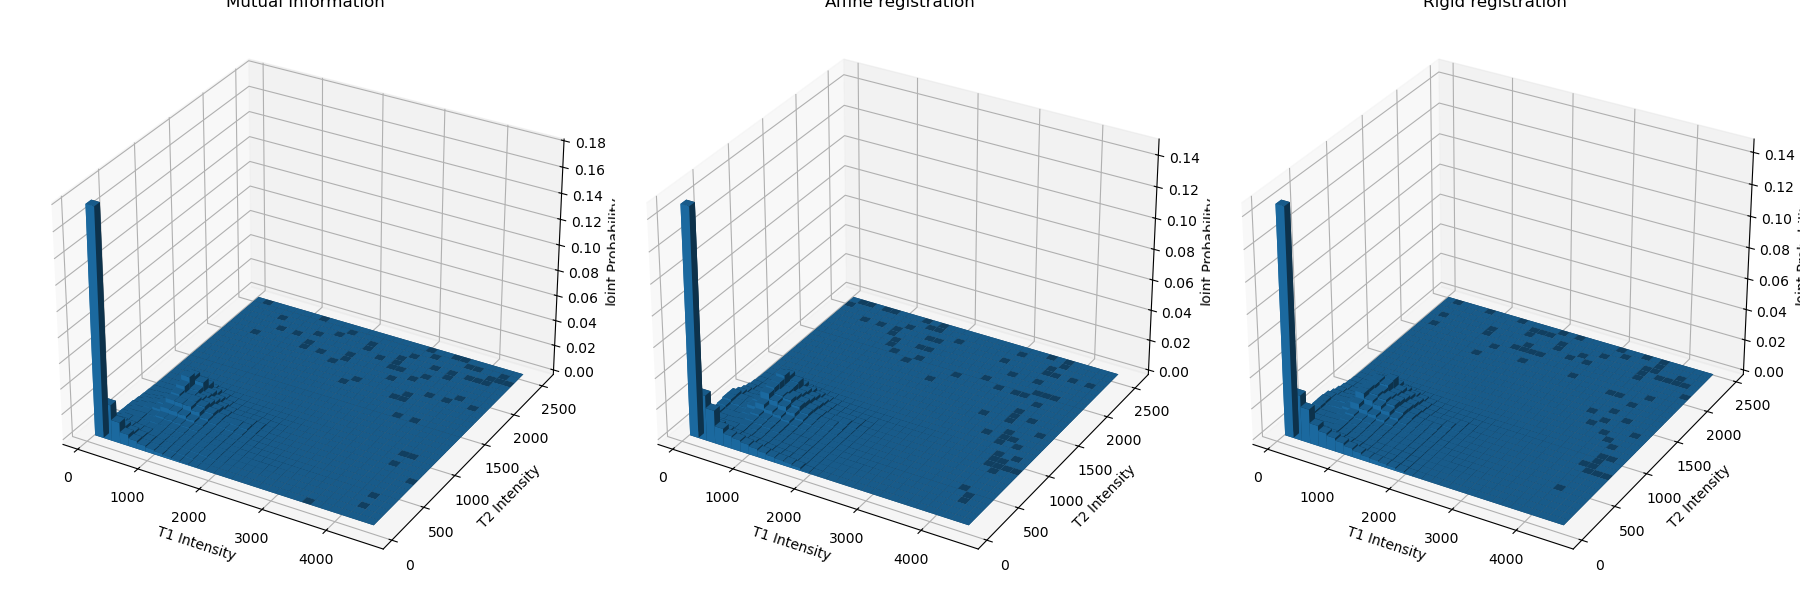

In [41]:
# --- Create figure with 3 subplots ---
fig = plt.figure(figsize=(18, 6))

ax1 = fig.add_subplot(131, projection='3d')
plot_joint_histogram(T1_data, best_resampled, "Mutual Information", ax=ax1)

ax2 = fig.add_subplot(132, projection='3d')
plot_joint_histogram(T1_data, affine_reg, "Affine registration", ax=ax2)

ax3 = fig.add_subplot(133, projection='3d')
plot_joint_histogram(T1_data, Rigid_reg, "Rigid registration", ax=ax3)

plt.tight_layout()
plt.show()

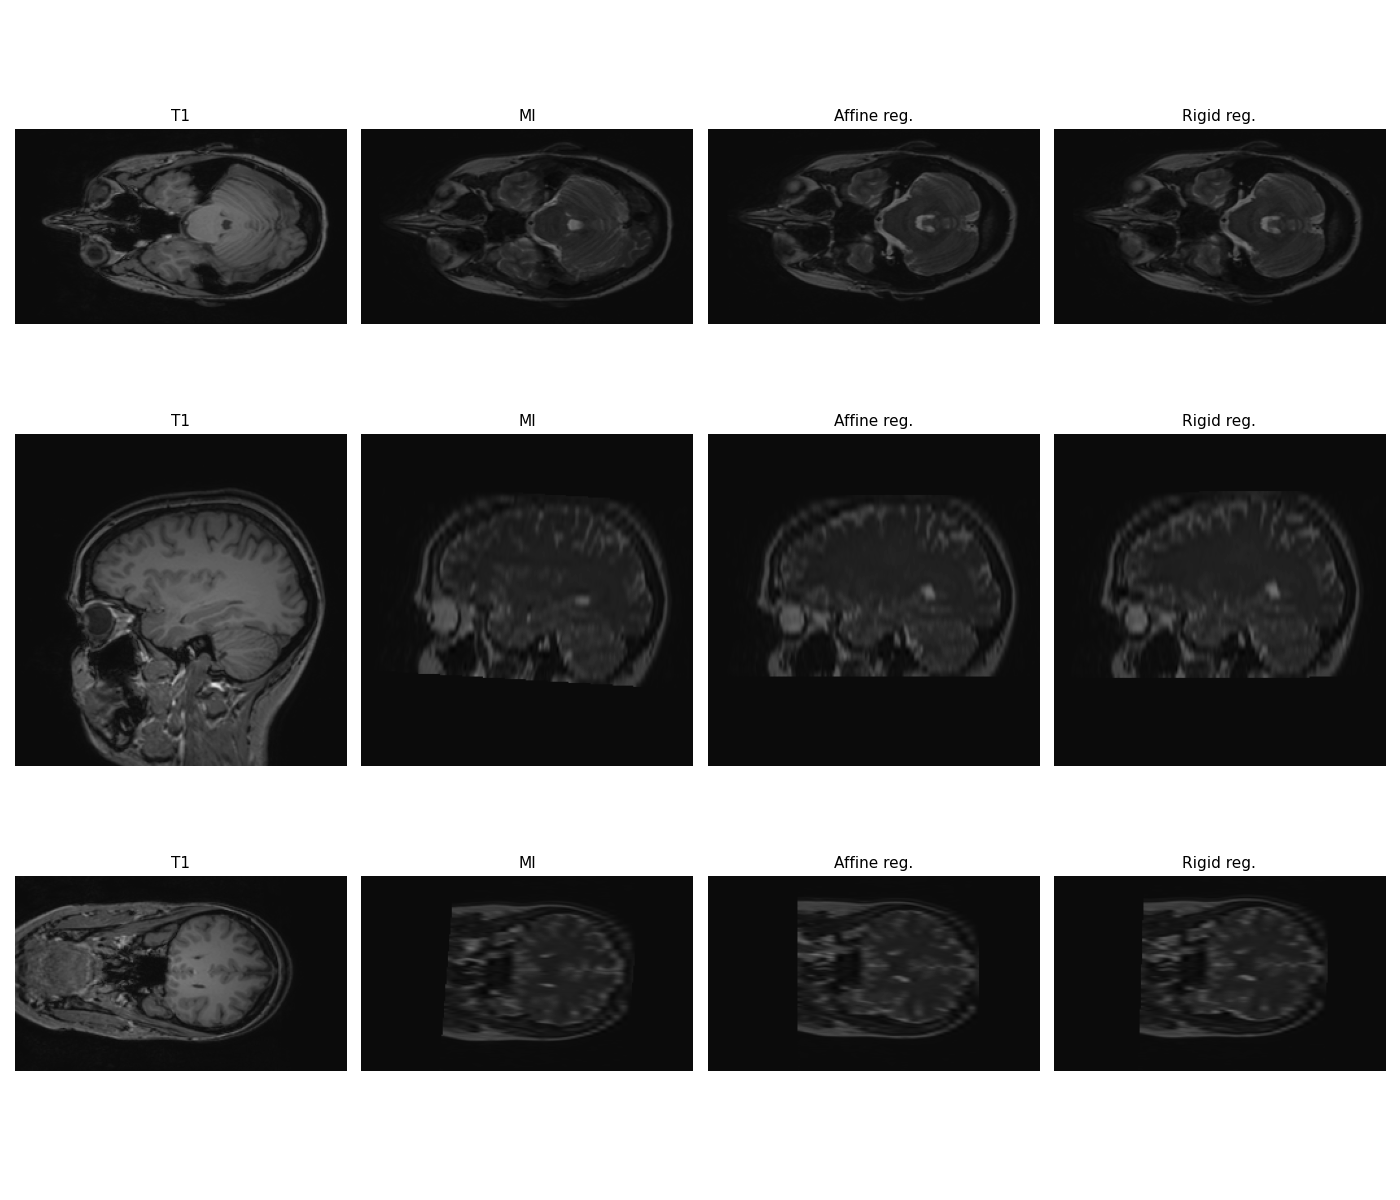

In [43]:
#Plotting them
fig, axes = plt.subplots(3, 4, figsize=(14, 12))

slice_idx = 100
vmin = min(T1_data.min(), T2_data_resampled.min(), best_resampled.min(), best_resampled_ew.min())
vmax = max(T1_data.max(), T2_data_resampled.max(), best_resampled.max(), best_resampled_ew.max())

titles = [
    ["T1", "MI", "Affine reg.", "Rigid reg."],
    ["T1", "MI", "Affine reg.", "Rigid reg."],
    ["T1", "MI", "Affine reg.", "Rigid reg."]
]
row_labels = ["Y-slice (x,z)", "Z-slice (x,y)", "X-slice (y,z)"]

# Y-slice (x, z) at y=slice_idx
axes[0, 0].imshow(T1_data[:,slice_idx,:].T, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
axes[0, 1].imshow(best_resampled[:,slice_idx,:].T, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
axes[0, 2].imshow(affine_reg[:,slice_idx,:].T, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
axes[0, 3].imshow(Rigid_reg[:,slice_idx,:].T, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)

# Z-slice (x, y) at z=slice_idx
axes[1, 0].imshow(T1_data[:,:,slice_idx].T, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
axes[1, 1].imshow(best_resampled[:,:,slice_idx].T, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
axes[1, 2].imshow(affine_reg[:,:,slice_idx].T, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
axes[1, 3].imshow(Rigid_reg[:,:,slice_idx].T, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)

# X-slice (y, z) at x=slice_idx
axes[2, 0].imshow(T1_data[slice_idx,:,:].T, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
axes[2, 1].imshow(best_resampled[slice_idx,:,:].T, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
axes[2, 2].imshow(affine_reg[slice_idx,:,:].T, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
axes[2, 3].imshow(Rigid_reg[slice_idx,:,:].T, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)

# Set titles and row labels
for i in range(3):
    for j in range(4):
        axes[i, j].set_title(titles[i][j], fontsize=11)
    axes[i, 0].set_ylabel(row_labels[i], fontsize=12)

# Remove axes
for ax_row in axes:
    for ax in ax_row:
        ax.axis('off')

plt.tight_layout()
plt.show()